In [1]:
import numpy as np
import pandas as pd

In [2]:
path = ("C:/Users/Ong Jia Yi/Desktop/STUDY/Summer 2021"
        "/Rotman MMA Summer 2021 Datathon")

# hereafter called 'the original dataframe'
load = pd.read_csv(path + "/NWHL.csv")

### DEFINITIONS
1) "outcomes" is defined to be the end of a sequence of prior events that are of interest.

## Function - prior_events

In [3]:
def prior_events(outcome_data):
    """Return a dataframe of the details of events that led to an outcome
    of interest.
    
    Arguments:
    outcome_data -- subset of the original Pandas DataFrame where
                    the outcome(s) of interest occur.Indexes of <outcome_data>
                    preserves that of the original dataframe.
    Returns:
    new_frame -- Pandas DataFrame containing info. on prior events.
    """
    new_frame = []
    for i in outcome_data.index:

        new_row = []
        for j in range(1, window_len+1):
            last_event = load.loc[i-j, outcome_data.columns]
            last_event = np.array(last_event)
            new_row.append(last_event)
        new_row = np.concatenate(new_row)

        new_frame.append([new_row])
    
    new_frame = pd.DataFrame(np.concatenate(new_frame))
    colnames = ["{}_l{}".format(name, i) for i in range(1, window_len+1) \
                for name in outcome_data.columns]
    new_frame.columns = colnames
    
    return new_frame

## Function - encode_player

In [4]:
def encode_players(outcome_data, prior_events_data, all_players, window_len):
    """Encode the outcome player and prior event player(s) by their IDs,
    which are their order of appearance in the original dataset.
    
    Arguments:
    outcome_data -- subset of the original Pandas DataFrame where
                    the outcome(s) of interest occur.
    prior_events_data -- output from prior_events() function with 
                         the same <outcome_data> input.
    all_players -- a Numpy array of all player names in the original 
                   dataset (no repetition).
    window_len -- (int) the number of previous events to include.
    
    Returns:
    player_encoded -- a Pandas DataFrame of the IDs of the player associated
                      to the outcome and prior events.
    """
    outcome_player = outcome_data.Player.reset_index(drop=True)
    prior_players = prior_events_data.filter(regex="Player").reset_index(drop=True)

    merged = pd.concat([outcome_player, prior_players], ignore_index=True, axis=1)
    
    # plus one so ID starts at 1
    players_encoded = merged.applymap(lambda x: np.where(x == all_players)[0][0] + 1)
    
    return players_encoded

## Function - one_hot_encoder

In [5]:
def one_hot_encoder(categories):
    """Creates a one-hot encoding for categorical data
    e.g. name of event or name of player.
    
    Arguments:
    categories -- Numpy array of all instances of the categorical data.
    
    Returns:
    oh_dict -- dictionary that maps instance of categorical data to 
               a Numpy array of one-hot encoding integers.
    """
    oh_mat = pd.get_dummies(categories)
    
    oh_dict = dict()
    for cat in categories:
        oh_dict[cat] = np.array(oh_mat.loc[:, cat])
        
    return oh_dict

## Function - encode_events

In [6]:
def encode_events(outcome_data, prior_events_data, event_oh, window_len):
    """Encode the outcome and prior event(s) by their IDs,
    which are their order of appearance in the original dataset.
    
    Arguments:
    outcome_data -- subset of the original Pandas DataFrame where
                    the outcome(s) of interest occur.
    prior_events_data -- output from prior_events() function with 
                         the same <outcome_data> input.
    event_oh -- one-hot-encoding dictionary for events.
    window_len -- (int) the number of previous events to include.
    
    Returns:
    events_encoded -- a Pandas DataFrame of the IDs of the event associated
                      to the outcome and prior events.
    """
    outcome_events = outcome_data.Event.reset_index(drop=True)
    outcome_events = pd.DataFrame(outcome_events).applymap(lambda x: event_oh[x])
    
    prior_events = prior_events_data.filter(regex="Event").reset_index(drop=True)
    prior_events = pd.DataFrame(prior_events).applymap(lambda x: event_oh[x])
    
    target_events_encoded = pd.DataFrame(outcome_events.iloc[:,0].to_list())
    events_encoded = pd.DataFrame(prior_events.iloc[:,0].to_list())
    
    for i in range(1, prior_events.shape[1]):
        prior_encoded_sub = pd.DataFrame(prior_events.iloc[:,i].to_list())
        events_encoded = pd.concat([events_encoded, prior_encoded_sub], axis=1)
    
    
    return target_events_encoded, events_encoded

## Implementing functions

In [7]:
# interested in events leading to outcomes of Shot/Goal
outcomes_interest = ["Shot", "Goal"]

# capture two prior events leading to outcome
window_len = 2

#  a list of variable names to describe prior events.
detail_names = ['Period', 'Home Team Skaters', 'Away Team Skaters',
                'X Coordinate', 'Y Coordinate', 'Player', 'Event']

# Subset rows only with Event == Shot/Goal
# Indexes of <outcome_data> preserves that of the original dataframe.
outcome_data = load.loc[load.Event.isin(outcomes_interest), detail_names]

In [8]:
prior_events_data = prior_events(outcome_data)
prior_events_data.head()

,Period_l1,Home Team Skaters_l1,Away Team Skaters_l1,X Coordinate_l1,Y Coordinate_l1,Player_l1,Event_l1,Period_l2,Home Team Skaters_l2,Away Team Skaters_l2,X Coordinate_l2,Y Coordinate_l2,Player_l2,Event_l2
0,1,5,5,125,28,McKenna Brand,Zone Entry,1,5,5,107,40,McKenna Brand,Puck Recovery
1,1,5,5,124,2,Allie Thunstrom,Zone Entry,1,5,5,112,0,Allie Thunstrom,Takeaway
2,1,5,5,168,10,Allie Thunstrom,Play,1,5,5,124,20,Nina Rodgers,Zone Entry
3,1,5,5,135,52,Jillian Dempsey,Play,1,5,5,125,70,Jillian Dempsey,Zone Entry
4,1,5,5,196,20,Lauren Kelly,Puck Recovery,1,5,5,174,82,Jillian Dempsey,Incomplete Play


In [9]:
encoded_players = encode_players(outcome_data, prior_events_data, load.Player.unique(), window_len)
encoded_players.head()

,0,1,2
0,2,2,2
1,11,11,11
2,13,11,13
3,2,1,1
4,19,19,1


In [10]:
event_oh = one_hot_encoder(load.Event.unique())
event_oh["Shot"]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [11]:
load.Event.unique()

array(['Faceoff Win', 'Puck Recovery', 'Zone Entry', 'Shot', 'Play',
       'Takeaway', 'Dump In/Out', 'Incomplete Play', 'Penalty Taken',
       'Goal'], dtype=object)

In [12]:
target_encoded_events, encoded_events = encode_events(outcome_data, prior_events_data, event_oh, window_len)
encoded_events.head()

,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Finalize data

### Event data

In [13]:
final_event_data_1 = outcome_data.drop(["Player", "Event"], axis=1)
final_event_data_1 = final_event_data_1.reset_index(drop=True)
final_event_data_1.head()

,Period,Home Team Skaters,Away Team Skaters,X Coordinate,Y Coordinate
0,1,5,5,131,28
1,1,5,5,162,2
2,1,5,5,167,18
3,1,5,5,175,68
4,1,5,5,196,20


In [14]:
final_event_data_2 = prior_events_data.drop(list(prior_events_data.filter(regex="Event|Player")), axis=1)
final_event_data_2 = final_event_data_2.reset_index(drop=True)
final_event_data_2.head()

,Period_l1,Home Team Skaters_l1,Away Team Skaters_l1,X Coordinate_l1,Y Coordinate_l1,Period_l2,Home Team Skaters_l2,Away Team Skaters_l2,X Coordinate_l2,Y Coordinate_l2
0,1,5,5,125,28,1,5,5,107,40
1,1,5,5,124,2,1,5,5,112,0
2,1,5,5,168,10,1,5,5,124,20
3,1,5,5,135,52,1,5,5,125,70
4,1,5,5,196,20,1,5,5,174,82


In [15]:
final_event_data = pd.concat([encoded_events, final_event_data_1, final_event_data_2], ignore_index=True, axis=1)
final_event_data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0,0,1,0,0,0,0,0,0,0,...,1,5,5,125,28,1,5,5,107,40
1,0,0,1,0,0,0,0,0,0,0,...,1,5,5,124,2,1,5,5,112,0
2,0,0,0,0,1,0,0,0,0,0,...,1,5,5,168,10,1,5,5,124,20
3,0,0,0,0,1,0,0,0,0,0,...,1,5,5,135,52,1,5,5,125,70
4,0,1,0,0,0,0,0,0,0,0,...,1,5,5,196,20,1,5,5,174,82


### Player data

In [16]:
encoded_players.head()

,0,1,2
0,2,2,2
1,11,11,11
2,13,11,13
3,2,1,1
4,19,19,1


## Train-test split

In [17]:
import random

In [18]:
nrow = encoded_players.shape[0]
random_ind = [i for i in range(0, nrow)]
random.shuffle(random_ind)

In [19]:
train_test_split = 0.9
split = int(train_test_split*nrow)

In [20]:
X_train_player = encoded_players.loc[random_ind[:split]].astype('float32')
X_train_event = final_event_data.loc[random_ind[:split]].astype('float32')
y_train = target_encoded_events.iloc[random_ind[:split], -1:].astype('float32') # last column is Goal
y_train = np.array(y_train).reshape(y_train.shape[0],)

X_test_player = encoded_players.loc[random_ind[split:]].astype('float32')
X_test_event = final_event_data.loc[random_ind[split:]].astype('float32')
y_test = target_encoded_events.iloc[random_ind[split:], -1:].astype('float32') # last column is Goal
y_test = np.array(y_test).reshape(y_test.shape[0],)

In [21]:
X_train_event.shape

(1786, 35)

In [22]:
y_train.shape

(1786,)

## Mixed Data Neural Network

In [23]:
from kerastuner import HyperModel

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Embedding, Input, Dense,
                                     Flatten, Activation, concatenate)
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

In [24]:
class Hypermodel(HyperModel):
    def __init__(self, input_shapes, n_players, emb_dim):
        self.input_shape_1 = input_shapes[0]
        self.input_shape_2 = input_shapes[1]
        self.n_players = n_players
        self.emb_dim = emb_dim
        
    def build(self, hp):
        input_1 = Input(shape=self.input_shape_1)
        input_2 = Input(shape=self.input_shape_2)
        
        # BRANCH 1
        branch_1 = Embedding(self.n_players, self.emb_dim, trainable=True)(input_1)
        
        branch_1 = Dense(units=hp.Int('branch_11', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=16),
                         activation=hp.Choice('activation_11', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(branch_1)
                
        branch_1 = Dense(units=hp.Int('branch_12', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=16),
                         activation=hp.Choice('activation_12', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(branch_1)
        
        branch_1 = Flatten(data_format=None)(branch_1)
        
        branch_1 = Model(inputs=input_1, outputs=branch_1)
        
        # BRANCH 2
        branch_2 = Dense(units=hp.Int('branch_21', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=16),
                         activation=hp.Choice('activation_21', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(input_2)
                
        branch_2 = Dense(units=hp.Int('branch_22', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=16),
                         activation=hp.Choice('activation_22', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(branch_2)
        
        branch_2 = Model(inputs=input_2, outputs=branch_2)
        
        # COMBINED BRANCH
        input_combined = concatenate([branch_1.output, branch_2.output])
        
        branch_c = Dense(units=hp.Int('branch_c', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=16),
                         activation=hp.Choice('activation_c', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(input_combined)
        
        branch_c = Dense(units=1, activation="sigmoid")(branch_c)
        
        model = Model(inputs=[branch_1.input, branch_2.input], outputs=branch_c)
        
        model.compile(
            optimizer=optimizers.Adam(
                learning_rate=hp.Float('learning_rate', 
                                       min_value=1e-4, 
                                       max_value=1e-2,
                                       sampling='LOG')
            ),
            loss='binary_crossentropy',
            metrics=[metrics.BinaryAccuracy(), metrics.AUC()]
        )
        
        return model

In [25]:
input_shape = [(X_train_player.shape[1],), (X_train_event.shape[1],)]
n_players = len(load.Player.unique())
emb_dim = 20

hypermodel = Hypermodel(input_shape, n_players, emb_dim)

## Hyperparameter Tuning

In [26]:
import kerastuner
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping

In [27]:
tuner = RandomSearch(
    hypermodel,
    objective=kerastuner.Objective("auc", direction="max"),
    seed=1,
    max_trials=20,
    executions_per_trial=2,
    directory='random_search',
    overwrite=True
)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
branch_11 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_11 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
branch_12 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_12 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
branch_21 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_21 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
branch_22 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_22 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
branch_c 

In [29]:
N_EPOCH_SEARCH = 20
tuner.search([np.array(X_train_player), np.array(X_train_event)], y_train, epochs=N_EPOCH_SEARCH, 
             validation_split=0.2, callbacks=[stop_early])

Trial 20 Complete [00h 00m 05s]
auc: 0.8482710123062134

Best auc So Far: 0.9534065127372742
Total elapsed time: 00h 02m 01s
INFO:tensorflow:Oracle triggered exit


In [30]:
tuner.results_summary(1)

Results summary
Results in random_search\untitled_project
Showing 1 best trials
Objective(name='auc', direction='max')
Trial summary
Hyperparameters:
branch_11: 48
activation_11: relu
branch_12: 16
activation_12: tanh
branch_21: 32
activation_21: tanh
branch_22: 64
activation_22: relu
branch_c: 80
activation_c: tanh
learning_rate: 0.001300398010371077
Score: 0.9534065127372742


## Final Model

In [32]:
best_hyppar = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hyppar)
final_model.fit([X_train_player, X_train_event], y_train, epochs=10, validation_split=0.2)

Epoch 1/10
45/45 [==============================] - 1s 9ms/step - loss: 0.2004 - binary_accuracy: 0.9475 - auc: 0.4776 - val_loss: 0.1694 - val_binary_accuracy: 0.9609 - val_auc: 0.5520
Epoch 2/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1534 - binary_accuracy: 0.9629 - auc: 0.6885 - val_loss: 0.1658 - val_binary_accuracy: 0.9609 - val_auc: 0.6358
Epoch 3/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1444 - binary_accuracy: 0.9629 - auc: 0.7548 - val_loss: 0.1722 - val_binary_accuracy: 0.9609 - val_auc: 0.6265
Epoch 4/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1260 - binary_accuracy: 0.9629 - auc: 0.8538 - val_loss: 0.1775 - val_binary_accuracy: 0.9609 - val_auc: 0.6736
Epoch 5/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1108 - binary_accuracy: 0.9629 - auc: 0.9052 - val_loss: 0.1823 - val_binary_accuracy: 0.9609 - val_auc: 0.6991
Epoch 6/10
45/45 [==============================] - 0s 2ms/step - loss

In [33]:
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3, 20)        2520        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3, 48)        1008        embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 35)]         0                                            
____________________________________________________________________________________________

In [35]:
loss, accuracy, auc = final_model.evaluate([X_test_player, X_test_event], y_test)

7/7 [==============================] - 0s 1ms/step - loss: 0.3742 - binary_accuracy: 0.9095 - auc: 0.5099


In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [38]:
pred = final_model.predict([X_test_player, X_test_event])
pred = (pred >= 0.5).astype('uint8')

In [39]:
cm = confusion_matrix(y_test, pred)
cm

array([[181,   9],
       [  9,   0]], dtype=int64)

In [40]:
roc_auc_score(y_test, pred)

0.4763157894736842

## Player Embeddings

In [43]:
embs = final_model.layers[1].get_weights()[0]

In [44]:
embs.shape

(126, 20)

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

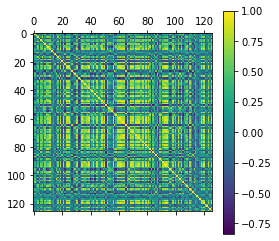

In [46]:
cos_sim = cosine_similarity(embs)
plt.matshow(cos_sim)
plt.colorbar()
plt.show()

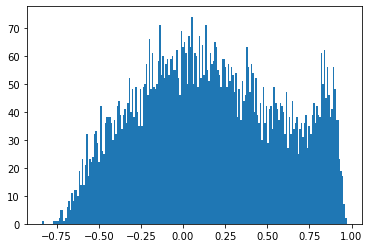

In [47]:
upp_tri = np.triu_indices(cos_sim.shape[0], 1)
plt.hist(cos_sim[upp_tri], bins=200)
plt.show()

In [145]:
def get_player_with_affinity(affinity, cos_sim, threshold):
    """Get a player pair within +/- threshold of the given affinity.
    If more than one pair, randomly selects a pair."""
    upp_tri_indx = np.triu_indices(cos_sim.shape[0], 1)
    upp_tri = cos_sim[upp_tri_indx]
    
    if isinstance(affinity, float):
        all_indx = np.where((upp_tri < affinity + threshold) & (upp_tri > affinity - threshold))[0]
        indx = random.choice(all_indx)
    elif affinity == "max":
        indx = np.argmax(upp_tri)
    elif affinity == "min":
        indx = np.argmin(upp_tri)
    else:
        return "Invalid affinity value. Input a float or 'min', 'max'"

    p1 = load.Player.unique()[upp_tri_indx[0][indx]]
    p2 = load.Player.unique()[upp_tri_indx[1][indx]]
    t1 = load.Team[load.Player == p1].unique()[0]
    t2 = load.Team[load.Player == p2].unique()[0]
    print("{} ({}) & {} ({}) has affinity {}".format(p1, t1, p2, t2, upp_tri[indx]))

In [172]:
get_player_with_affinity(0.7, cos_sim, 0.01)

Carlee Turner (Boston Pride) & Lovisa Selander (Boston Pride) has affinity 0.6929029822349548


In [53]:
def get_affinity(player_1, player_2, cos_sim):
    """Returns the cosine similarity between the vector embeddings
    of <player_1> and <player_2>.
    
    Arguments:
    player_1, player_2 -- names of player 1 and 2
    cos_sim -- cosine similarity matrix
    """
    id_1 = np.where(load.Player.unique() == player_1)[0][0]
    id_2 = np.where(load.Player.unique() == player_2)[0][0]
    
    return cos_sim[id_1, id_2]

In [62]:
# affinity of specific pair
get_affinity('Kaleigh Fratkin', 'Mallory Souliotis', cos_sim)

0.49591717